## Question Answering in RAG using Llama-Index

![alt text](image-1.png)

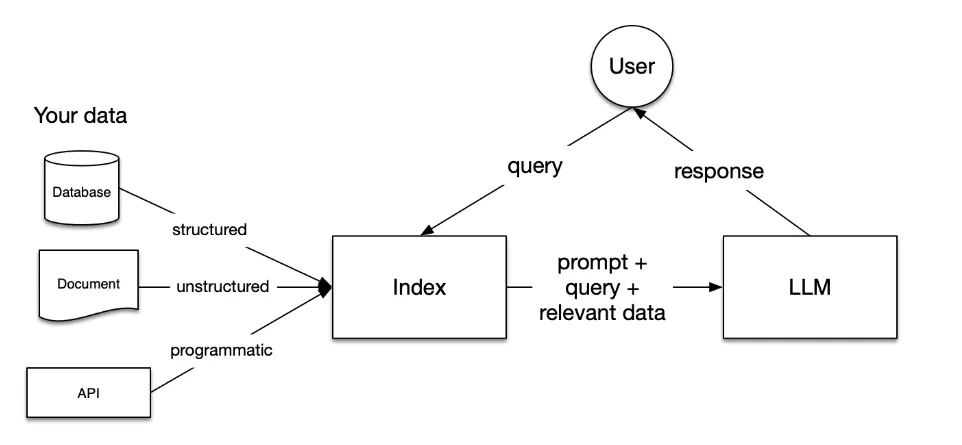

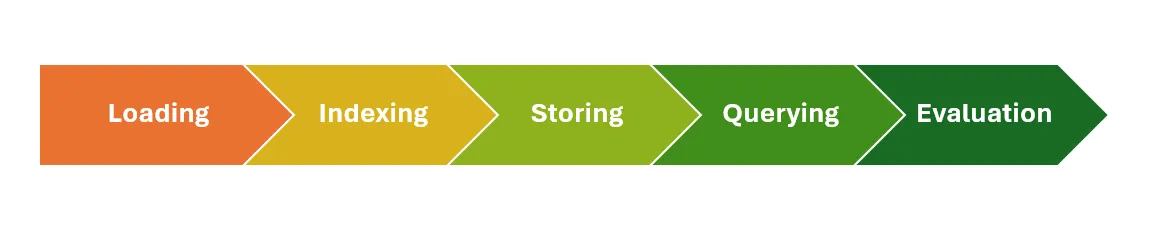

#### 1 Loading
means bringing your data from wherever it is stored into our system.
- **Nodes and Documents**: metadata & relationships
    - Document: It is a generic container around any data source — for instance, a PDF, an API output, or retrieved data from a database.
    - Nodes: A Node represents a “chunk” of a source Document, whether that is a text chunk, an image, or other. Similar to Documents, they contain metadata and relationship information with other nodes.

- **Connectors**
Special tools we use to pick uppapers from different sources, and then organize them into Documents and Nodes

#### 2 Indexing and Embedding

- **Indexs**
Think of indexes like a big filing system for our papers.

- **Embeddings**
convert the content into vertors

#### 3 Storing

- **Storing your index**: Think of it like taking a snapshot of your entire filing system. 
- **Other metadata**: additional notes, tabular data 




#### Querying

- **Querying**: search query

- **Retrievers**: 
Extract relavant knowledge from embeded data. The efficiency and accuracy of these retrievers are crucial.

- **Routers**:
Hierarchical structure to find the relavant knowledge. 

- **Node Postprocessors**: Help to organize the results
rearrange the papers based on relevance, filter out any irrelevant ones, or even add additional information to help you better understand the results.

- **Response Synthesizers**:
a response synthesizer takes all this information and presents it to you in a clear and understandable wa

### Evaluation

- **Accuracy**: how often you solution gets the right answer.
- **Faithfulness**: how closely your solution matches what’s expected or true.
- **Speed**: how quickly your solution works.




## 1.Loaders

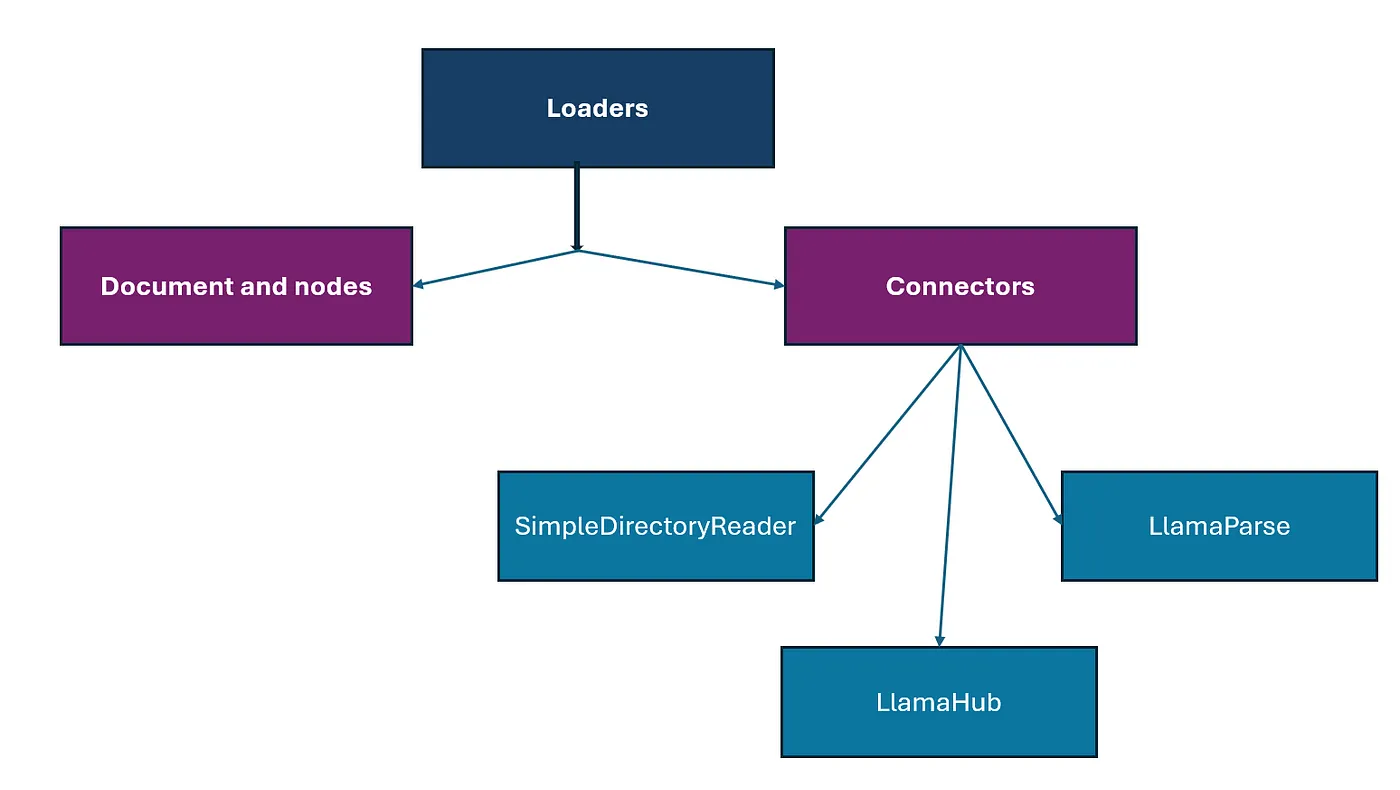

#### Lodering method 1 - Connectors: Methods to Load the data

- **SimpleDirectoryReader**: built-in loader for loading all sorts of file types from a local directory
- **LlamaParse**: LlamaIndex’s official tool for PDF parsing, available as a managed API.
- **LlamaHub**: registry of hundreds of data loading libraries to ingest data from any source.


In [ ]:
# SimpleDirectoryReader

#method 1:
#read the file
reader = SimpleDirectoryReader(input_files=["final_text.txt"])
docs = reader.load_data()


#method 2:automatically sets the metadata of each document according to filename_fn
from llama_index.core import SimpleDirectoryReader

filename_fn = lambda filename: {"file_name": filename}
documents = SimpleDirectoryReader(
    "./data", file_metadata=filename_fn
).load_data()


#method 3: Exclude files of certain extensions
from llama_docs_bot.markdown_docs_reader import MarkdownDocsReader
from llama_index import SimpleDirectoryReader

def load_markdown_docs(filepath):
   
    loader = SimpleDirectoryReader(
        input_dir=filepath, 
        required_exts=[".md"],
        exclude=["*.rst", "*.ipynb", "*.py", "*.bat",".txt","*.png", "*.jpg", "*.jpeg", "*.csv", "*.html", "*.js", "*.css", "*.pdf", "*.json"],
        file_extractor={".md": MarkdownDocsReader()},
        recursive=True
    )

    documents = loader.load_data()

    # exclude some metadata from the LLM
    for doc in documents:
        doc.excluded_llm_metadata_keys = ["File Name", "Content Type", "Header Path"]
   
    return documents


In [ ]:
# LlamaParser

import nest_asyncio

nest_asyncio.apply()

from llama_parse import LlamaParse

parser = LlamaParse(
    api_key="llx-...",  # can also be set in your env as LLAMA_CLOUD_API_KEY
    result_type="markdown",  # "markdown" and "text" are available
    verbose=True,
)

# sync
documents = parser.load_data("./my_file.pdf")

# sync batch
documents = parser.load_data(["./my_file1.pdf", "./my_file2.pdf"])

# async
documents = await parser.aload_data("./my_file.pdf")

# async batch
documents = await parser.aload_data(["./my_file1.pdf", "./my_file2.pdf"])


##### Loading - Method 2 - Creating document - without meta data

In [ ]:
#  
from llama_index.core import Document

#single text
doc = Document(text="text")

#Adding various texts into different document objects
text_list = [text1, text2,text3]
doc= [Document(text=t) for t in text_list]

##### Loading - Method 2 - Creating a document - with the meta data

In [ ]:
#method 1: Creating a document with the meta data
document = Document(
    text="text",
    metadata={"filename": "<doc_file_name>", "category": "<category>"},
)

#method 2: After document is created adding metadata to it
document = Document(
    text="text",
    metadata={"filename": "<doc_file_name>", "category": "<category>"},
)


#Method 3: crating a document object 
documents = Document(text = "\n\n".join([doc.text for doc in docs]))

##### Loading -  Creating a Node - with the meta data
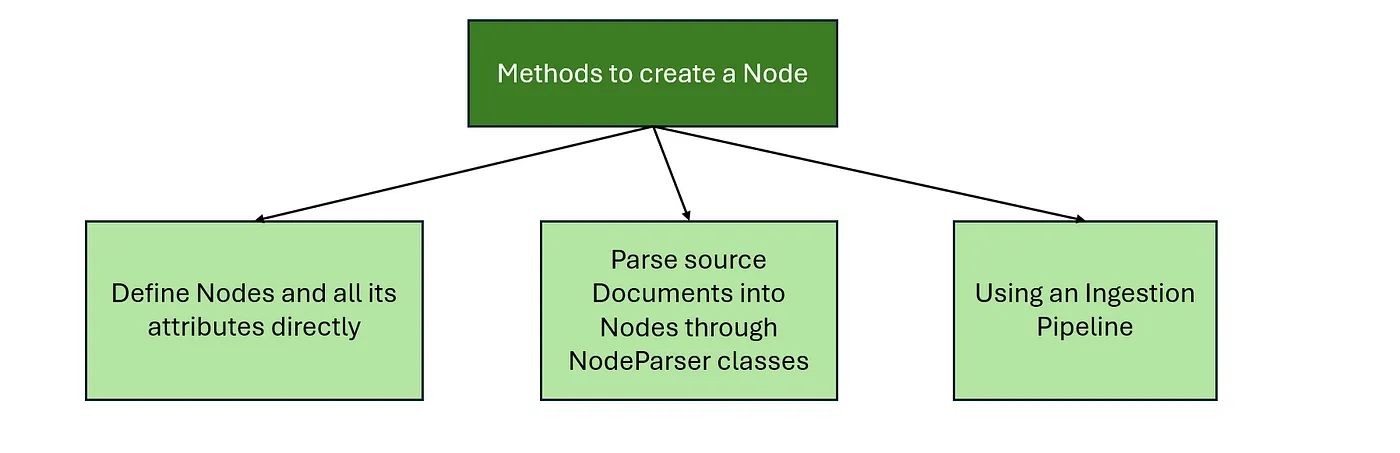

In [ ]:
# Method 1 - You can choose to define Nodes and all its attributes directly.


from llama_index.core.schema import TextNode, NodeRelationship, RelatedNodeInfo

node1 = TextNode(text="<text_chunk>", id_="<node_id>")
node2 = TextNode(text="<text_chunk>", id_="<node_id>")
# set relationships
node1.relationships[NodeRelationship.NEXT] = RelatedNodeInfo(
    node_id=node2.node_id
)
node2.relationships[NodeRelationship.PREVIOUS] = RelatedNodeInfo(
    node_id=node1.node_id
)
nodes = [node1, node2]

# Method 2 - “parse” source Documents into Nodes through our NodeParser classes.
from llama_index.core.node_parser import SentenceSplitter

parser = SentenceSplitter()
nodes = parser.get_nodes_from_documents(documents)


# Method 3 - Using an Ingestion Pipeline

from llama_index.core import Document
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.extractors import TitleExtractor
from llama_index.core.ingestion import IngestionPipeline, IngestionCache


# create the pipeline with transformations
pipeline = IngestionPipeline(
    transformations=[
        SentenceSplitter(chunk_size=25, chunk_overlap=0),
        TitleExtractor(),
        OpenAIEmbedding(),
    ]
)
# run the pipeline
nodes = pipeline.run(documents=[Document.example()])